## Trouble installing fastai library?

Here is a [guide to troubleshooting](https://docs.fast.ai/troubleshoot.html) problems with fastai installation.  By far, the most common problem is having fastai installed for a different environment/different Python installation than the one your Jupyter notebook is using (you can have Python installed in multiple places on your computer and not even realize it!). Or, you might have different versions of fastai installed in your different environments/different Python installations (and the one you are running in Jupyter notebook could be out of date, even if you installed version 1.0 somewhere else). For both of these problems, please [see this entry](https://docs.fast.ai/troubleshoot.html#modulenotfounderror-no-module-named-fastaivision).

## More detail about randomized SVD

I didn't cover how randomized SVD worked, because we aren't going to learn about it in detail in this course.  The main things I want you to know about randomized SVD are:
- **it is fast**
- **it gives us a truncated SVD** (whereas with traditional SVD, we are usually throwing away small singular values and their corresponding columns)

If you were curious to know more, two keys are:
- It is often useful to be able to reduce dimensionality of data in a way that preserves distances. The Johnson–Lindenstrauss lemma is a classic result of this type.  [Johnson-Lindenstrauss Lemma](https://en.wikipedia.org/wiki/Johnson%E2%80%93Lindenstrauss_lemma): a small set of points in a high-dimensional space can be embedded into a space of much lower dimension in such a way that distances between the points are nearly preserved (proof uses random projections).
- We haven't found a better general SVD method, we'll just use the method we have on a smaller matrix.  

Below is an over-simplified version of `randomized_svd` (you wouldn't want to use this in practice, but it covers the core ideas).  The main part to notice is that we multiply our original matrix by a smaller random matrix (`M @ rand_matrix`) to produce `smaller_matrix`, and then use our same `np.linalg.svd` as before:

```
def randomized_svd(M, k=10):
    m, n = M.shape
    transpose = False
    if m < n:
        transpose = True
        M = M.T
        
    rand_matrix = np.random.normal(size=(M.shape[1], k))  # short side by k
    Q, _ = np.linalg.qr(M @ rand_matrix, mode='reduced')  # long side by k
    smaller_matrix = Q.T @ M                              # k by short side
    U_hat, s, V = np.linalg.svd(smaller_matrix, full_matrices=False)
    U = Q @ U_hat
    
    if transpose:
        return V.T, s.T, U.T
    else:
        return U, s, V
```

This code snippet is from this [randomized-SVD jupyter notebook](https://github.com/fastai/randomized-SVD/blob/master/Randomized%20SVD.ipynb) which was the demo I used for my PyBay talk on [Using randomness to make code much faster](https://www.youtube.com/watch?v=7i6kBz1kZ-A&list=PLtmWHNX-gukLQlMvtRJ19s7-8MrnRV6h6&index=7).

## Bayes Theorem

Ex: Physicist Leonard Mlodinow tested positive for HIV in 1989.  
	His doctor said there was a 99.9% chance he had HIV.  
   
A = positive test results		
B = having HIV


True positives: 	$P(A|B) = 99.9\%$	

Prevalence:	$P(B)= 0.01\%$

False positives:	$P(A|B^C) = 0.1\%$	

Was his doctor correct?

This example is from the book:

<img src="images/drunkards-walk.jpg" alt="drunkard's walk" style="width: 30%"/>

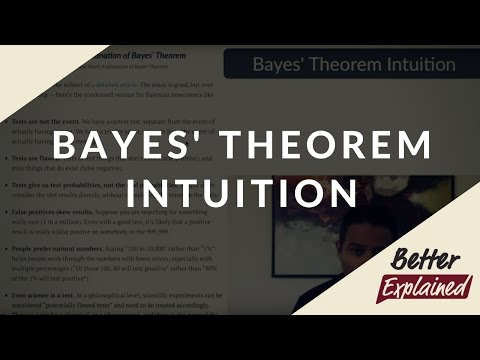

In [5]:
from IPython.display import YouTubeVideo

YouTubeVideo("YBvilAYd5sE")

Bayes Theorem (for conditional probabilities): $$ P(A | B) P(B) = P(B | A) P(A) $$

### Answer

Solution:

<img src="images/mlodinow-false-pos.png" alt="Mlodinow" style="width: 80%"/>

## Derivation of Naive Bayes

We want to calculate the probability that the review "I loved it" is positive.  Using Bayes Theorem, we can rewrite this:

$$ P(\text{pos} | \text{"I"}, \text{"loved"}, \text{"it"}) = \frac{P(\text{"I"}, \text{"loved"}, \text{"it"}, | \text{pos}) \cdot P(\text{"loved"} | \text{pos}) \cdot P(\text{"it"} | \text{pos}) \cdot P(\text{pos})}{P(\text{"I"}, \text{"loved"}, \text{"it})}$$

The "naive" part of Naive Bayes is that we will assume that the probabilities of the different words are all independent.

$$ P(\text{pos} | \text{"I"}, \text{"loved"}, \text{"it"}) = \frac{P(\text{"I"} | \text{pos}) \cdot P(\text{"loved"} | \text{pos}) \cdot P(\text{"it"} | \text{pos}) \cdot P(\text{pos})}{P(\text{"I"}, \text{"loved"}, \text{"it})}$$

We do the same calculation to see how likely it is the review is negative, and then choose whichever is larger.

$$ P(\text{neg} | \text{"I"}, \text{"loved"}, \text{"it"}) = \frac{P(\text{"I"} | \text{neg}) \cdot P(\text{"loved"} | \text{neg}) \cdot P(\text{"it"} | \text{neg}) \cdot P(\text{neg})}{P(\text{"I"}, \text{"loved"}, \text{"it})}$$

We will add one to avoid dividing by zero (or something close to it).  Similarly, we take logarithms to avoid multiplying by a lot of tiny values.  For the reasons we want to avoid this, please see the next section on numerical stability:

More reading: [Using log-probabilities for Naive Bayes](http://www.cs.rhodes.edu/~kirlinp/courses/ai/f18/projects/proj3/naive-bayes-log-probs.pdf)

## Numerical Stability

#### Exercise

Take a moment to look at the function $f$ below.  Before you try running it, write on paper what the output would be of $x_1 = f(\frac{1}{10})$.  Now, (still on paper) plug that back into $f$ and calculate $x_2 = f(x_1)$.  Keep going for 10 iterations.

This example is taken from page 107 of *Numerical Methods*, by Greenbaum and Chartier.

In [3]:
def f(x):
    if x <= 1/2:
        return 2 * x
    if x > 1/2:
        return 2*x - 1

Only after you've written down what you think the answer should be, run the code below:

In [4]:
x = 1/10
for i in range(80):
    print(x)
    x = f(x)

0.1
0.2
0.4
0.8
0.6000000000000001
0.20000000000000018
0.40000000000000036
0.8000000000000007
0.6000000000000014
0.20000000000000284
0.4000000000000057
0.8000000000000114
0.6000000000000227
0.20000000000004547
0.40000000000009095
0.8000000000001819
0.6000000000003638
0.2000000000007276
0.4000000000014552
0.8000000000029104
0.6000000000058208
0.20000000001164153
0.40000000002328306
0.8000000000465661
0.6000000000931323
0.20000000018626451
0.40000000037252903
0.8000000007450581
0.6000000014901161
0.20000000298023224
0.4000000059604645
0.800000011920929
0.6000000238418579
0.20000004768371582
0.40000009536743164
0.8000001907348633
0.6000003814697266
0.20000076293945312
0.40000152587890625
0.8000030517578125
0.600006103515625
0.20001220703125
0.4000244140625
0.800048828125
0.60009765625
0.2001953125
0.400390625
0.80078125
0.6015625
0.203125
0.40625
0.8125
0.625
0.25
0.5
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0
1.0


What went wrong?

### Problem: math is continuous & infinite, but computers are discrete & finite

Two Limitations of computer representations of numbers:
1. they can't be arbitrarily large or small
2. there must be gaps between them

The reason we need to care about accuracy, is because computers can't store infinitely accurate numbers.  It's possible to create calculations that give very wrong answers (particularly when repeating an operation many times, since each operation could multiply the error).

How computers store numbers:

<img src="images/fpa.png" alt="floating point" style="width: 60%"/>

The *mantissa* can also be referred to as the *significand*.

IEEE Double precision arithmetic:
- Numbers can be as large as $1.79 \times 10^{308}$ and as small as $2.23 \times 10^{-308}$.
- The interval $[1,2]$ is represented by discrete subset: 
$$1, \: 1+2^{-52}, \: 1+2 \times 2^{-52},\: 1+3 \times 2^{-52},\: \ldots, 2$$

- The interval $[2,4]$ is represented:
$$2, \: 2+2^{-51}, \: 2+2 \times 2^{-51},\: 2+3 \times 2^{-51},\: \ldots, 4$$


Floats and doubles are not equidistant:

<img src="images/fltscale-wh.png" alt="floating point" style="width: 100%"/>
Source: [What you never wanted to know about floating point but will be forced to find out](http://www.volkerschatz.com/science/float.html)

**Machine Epsilon**

Half the distance between 1 and the next larger number. This can vary by computer.  IEEE standards for double precision specify $$ \varepsilon_{machine} = 2^{-53} \approx 1.11 \times 10^{-16}$$

**Two important properties of Floating Point Arithmetic**:

- The difference between a real number $x$ and its closest floating point approximation $fl(x)$ is always smaller than $\varepsilon_{machine}$ in relative terms.  For some $\varepsilon$, where $\lvert \varepsilon \rvert \leq \varepsilon_{machine}$, $$fl(x)=x \cdot (1 + \varepsilon)$$

- Where * is any operation ($+, -, \times, \div$), and $\circledast$ is its floating point analogue,
    $$ x \circledast y = (x * y)(1 + \varepsilon)$$
for some $\varepsilon$, where $\lvert \varepsilon \rvert \leq \varepsilon_{machine}$
That is, every operation of floating point arithmetic is exact up to a relative error of size at most $\varepsilon_{machine}$

## Speed of different types of memory

This course is 90% NLP and 10% things I want to make sure you see before the end of your MSDS.

Here are some *numbers everyone should know* (from the legendary [Jeff Dean](http://static.googleusercontent.com/media/research.google.com/en/us/people/jeff/stanford-295-talk.pdf)):
- L1 cache reference 0.5 ns
- L2 cache reference 7 ns
- Main memory reference/RAM 100 ns
- Send 2K bytes over 1 Gbps network 20,000 ns
- Read 1 MB sequentially from memory 250,000 ns
- Round trip within same datacenter 500,000 ns
- Disk seek 10,000,000 ns
- Read 1 MB sequentially from network 10,000,000 ns
- Read 1 MB sequentially from disk 30,000,000 ns
- Send packet CA->Netherlands->CA 150,000,000 ns

And here is an updated, interactive [version](https://people.eecs.berkeley.edu/~rcs/research/interactive_latency.html), which includes a timeline of how these numbers have changed.

**Key take-away**: Each successive memory type is (at least) an order of magnitude worse than the one before it.  Disk seeks are **very slow**.

## Revisiting Naive Bayes in an Excel Spreadsheet

Let's calculate naive bayes in a spreadsheet to get a more visual picture of what is going on.  Here's how I processed the data for this:

### Loading our data

In [6]:
from fastai import *
from fastai.text import *

In [7]:
path = untar_data(URLs.IMDB_SAMPLE)

In [8]:
movie_reviews = (TextList.from_csv(path, 'texts.csv', cols='text')
                         .split_from_df(col=2)
                         .label_from_df(cols=0))

In [9]:
def get_term_doc_matrix(label_list, vocab_len):
    j_indices = []
    indptr = []
    values = []
    indptr.append(0)

    for i, doc in enumerate(label_list):
        feature_counter = Counter(doc.data)
        j_indices.extend(feature_counter.keys())
        values.extend(feature_counter.values())
        indptr.append(len(j_indices))
        
#     return (values, j_indices, indptr)

    return scipy.sparse.csr_matrix((values, j_indices, indptr),
                                   shape=(len(indptr) - 1, vocab_len),
                                   dtype=int)

In [10]:
trn_term_doc = get_term_doc_matrix(movie_reviews.train.x, len(movie_reviews.vocab.itos))

### Getting data for our spreadsheet

To keep our spreadsheet manageable, we will just get the 40 shortest reviews:

In [11]:
inds = np.argpartition(np.count_nonzero(trn_term_doc.todense(), 1), 40, axis=0)[:40]

In [12]:
inds = np.squeeze(np.asarray(inds))

Let's get the text from these 40 shortest reviews:

In [13]:
list_text = [movie_reviews.train.x[i].text for i in inds]

Get counts for all vocab used in our selection of the 40 shortest reviews:

In [15]:
vocab_used = defaultdict(int)

for i in inds:
     for val in movie_reviews.train.x[i].data:
        vocab_used[val] += 1

Let's choose the words that are used at least 6 times (so not too rare), but less than 30 (so not too common).  You could try experimenting with different cut-off points on your own:

In [16]:
interesting_inds = [key for key, val in vocab_used.items() if val < 30 and val >6]

In [17]:
len(interesting_inds)

44

I copied the vocab and text of the movie reviews directly from here to paste into the spreadsheet:

In [18]:
[movie_reviews.vocab.itos[i] for i in interesting_inds]

['so',
 'bad',
 'very',
 'acting',
 '\n \n ',
 'do',
 'xxup',
 'film',
 'from',
 'some',
 'if',
 'are',
 'for',
 'up',
 'one',
 'have',
 'all',
 'an',
 'no',
 'just',
 'like',
 'good',
 'great',
 'but',
 '...',
 'about',
 'movies',
 'seen',
 'with',
 '!',
 'me',
 'as',
 "'s",
 'was',
 'that',
 'out',
 '"',
 'on',
 "n't",
 'story',
 '-',
 '(',
 ')',
 'not']

In [541]:
list_text

["xxbos xxmaj this movie is so bad , i knew how it ends right after this little girl killed the first person . xxmaj very bad acting very bad plot very bad movie \n \n  do yourself a xxunk and xxup don't watch it 1 / 10",
 'xxbos i found this film to funny from the start . xxmaj john xxmaj waters use of characters reminded of some of the down to earth characters from xxmaj xxunk films . xxmaj christina xxmaj xxunk has once again xxunk her abilities in this film . xxmaj if you are looking for a fun movie without xxunk , i recommend this film .',
 'xxbos xxmaj if you ever see a stand up comedy movie this is the one . xxmaj you will laugh xxunk if you have any sense of humor at all . xxmaj this is a once in a lifetime performance from a once in a lifetime performer . xxmaj this is a stand up standard .',
 'xxbos xxmaj another movie to suffer without an adventure to run , no xxunk to solve . xxmaj just an xxunk man , acting like an animal . xxmaj no a good reason to take this journey . xxm

In [605]:
x = trn_term_doc[inds,:]
y = movie_reviews.train.y[inds]

#### Export to CSVs

Let's export the term-document matrix and the labels to CSVs.  

In [493]:
from IPython.display import FileLink, FileLinks

In [607]:
np.savetxt("x.csv", x.todense()[:,interesting_inds], delimiter=",", fmt='%.14f')
FileLink('x.csv')

/home/racheltho/git/nlp/x.csv

In [584]:
np.savetxt("y.csv", y, delimiter=",", fmt="%i")
FileLink('y.csv')

/home/racheltho/git/nlp/y.csv